# Latent Space Illumination of MNIST GAN
Generative Adversarial Networks (GANs) can be used to generate new images from random latent vectors, but they are ubiquitous when images with specific measures are required. In [Fontaine 2020](https://arxiv.org/pdf/2007.05674.pdf), Quality-Diversity algorithms are used to search for the latent space of a GAN to generate levels of Super Mario Bros with specific game measure. Such kind of problem is called Latent Space Illumination (LSI).

In this tutorial, we apply LSI to a trained GAN of MNIST dataset to generate digits with various boldness and lightness.

# Setup
First, we install libraries required for this tutorial and import them.

In [1]:
%pip install ribs torch torchvision numpy matplotlib

You should consider upgrading via the '/home/lunjohnzhang/anaconda3/envs/pyribs/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision

Then we construct the GAN (generator and discriminator) and a [LENET-5](https://en.wikipedia.org/wiki/LeNet) MNIST classifier.

In [3]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [5]:
LENET5 = nn.Sequential(
    nn.Conv2d(1, 6, (5, 5), stride=1, padding=0),  # (1,28,28) -> (6,24,24)
    nn.MaxPool2d(2),  # (6,24,24) -> (6,12,12)
    nn.ReLU(),
    nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),  # (6,12,12) -> (16,8,8)
    nn.MaxPool2d(2),  # (16,8,8) -> (16,4,4)
    nn.ReLU(),
    nn.Flatten(),  # (16,4,4) -> (256,)
    nn.Linear(256, 120),  # (256,) -> (120,)
    nn.ReLU(),
    nn.Linear(120, 84),  # (120,) -> (84,)
    nn.ReLU(),
    nn.Linear(84, 10),  # (84,) -> (10,)
    nn.LogSoftmax(dim=1),  # (10,) log probabilities
)

Then we download the trained GAN and the LENET-5 classifier, and load them to the constructed networks. We used code from [this tutorial](https://debuggercafe.com/generating-mnist-digit-images-using-vanilla-gan-with-pytorch/) to train the GAN for MNIST and [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) tutorial to train the classifier.


In [6]:
import os
import urllib.request
nz = 128

if not os.path.isdir("_static"):
  os.mkdir("_static")

urllib.request.urlretrieve("https://github.com/icaros-usc/pyribs/blob/lsi_tutorial/examples/tutorials/_static/mnist_generator.pth?raw=true", 
                           "_static/mnist_generator.pth")

urllib.request.urlretrieve("https://github.com/icaros-usc/pyribs/blob/lsi_tutorial/examples/tutorials/_static/mnist_discriminator.pth?raw=true", 
                           "_static/mnist_discriminator.pth")

urllib.request.urlretrieve("https://github.com/icaros-usc/pyribs/blob/lsi_tutorial/examples/tutorials/_static/mnist_classifier.pth?raw=true", 
                           "_static/mnist_classifier.pth")

device = torch.device('cpu')
g_state_dict = torch.load("_static/mnist_generator.pth",
                          map_location=device)

d_state_dict = torch.load("_static/mnist_discriminator.pth",
                          map_location=device)

c_state_dict = torch.load("_static/mnist_classifier.pth", 
                          map_location=device)

generator = Generator(nz)
discriminator = Discriminator()

generator.load_state_dict(g_state_dict)
discriminator.load_state_dict(d_state_dict)
LENET5.load_state_dict(c_state_dict)

<All keys matched successfully>

# LSI with CMA-ME on MNIST GAN
After getting the GAN and the classifier, we can start exploring the latent space of the GAN using QD algorithm. We use Covariance Metrix Adaptation MAP-Elites (CMA-ME) proposed by [Fontaine 2020](https://arxiv.org/pdf/1912.02400.pdf).

In pyribs, based on [Fontaine 2020](https://arxiv.org/pdf/1912.02400.pdf), we implement CMA-ME with a `GridArchive` and several emitters including `RandomDirectionEmitter`, `OptimizingEmitter`, and `ImprovementEmitter`. Here we use 5 `ImprovementEmitter`s to generate solutions.

We choose "boldness" and "lightness" as the behavior characteristics, so we will have a 2D behavior space. We define "boldness" of a digit to be the number of white pixels and "lightness" to be the mean value of the white pixels in an MNIST image. For simplicity, we define "white" pixel as pixels with gray scale value larger than or equal to 0.5. Therefore, the upper and lower bounds of "boldness" is `[0, 784]` as there are 784 pixels in one image and those of "lightness" is `[0.5, 1]`.

In [7]:
from ribs.archives import GridArchive
archive = GridArchive([200, 200], [(0, 784), (0.5, 1)], dtype=np.float64) # size and whiteness

We use 5 `ImprovementEmitter`s with batch size 30. The emitters begins with an image filled with 0.5 and has $\sigma=0.5$

In [8]:
from ribs.emitters import ImprovementEmitter

img_size = (28, 28)
flat_img_size = 784  # 28 * 28
batch_size = 30
emitters = [
    ImprovementEmitter(
        archive,
        # Start with a grey image.
        np.full(nz, 0.5, dtype=np.float64),
        0.2,
        batch_size=batch_size,
    ) for _ in range(5)
]

Finally, we construct the optimizer to connect the archive and emitter together.

In [9]:
from ribs.optimizers import Optimizer

optimizer = Optimizer(archive, emitters)

With the components created, we now generate latent vectors. As we use 5 emitters with batch size of 30 and run 30,000 iterations, we evaluate 30,000 * 30 * 5 = 4,500,000 latent vectors in total.

We want to search for one specific digit, but the GAN is trained on all MNIST digits. Therefore, we use a separate MNIST digit classifier as the fitness function to optimize. In our case, we optimize the classification score of digit 8.

In [10]:
total_itrs = 30_000
start_time = time.time()

for itr in range(1, total_itrs + 1):
    sols = optimizer.ask()

    with torch.no_grad():
        generated_imgs = generator(torch.tensor(sols, 
            dtype=torch.float32)) # n_sol x 28 x 28

        # We optimize the score of the digit being 8.
        # You can also optimize the score of other digits.
        objs = np.exp(LENET5(generated_imgs).numpy()[:,8])

        generated_imgs = generated_imgs.cpu()\
                        .numpy().reshape((-1, flat_img_size))

        # normalize the values to [0, 1]
        normalized = (generated_imgs - np.min(generated_imgs))/ \
                     (np.max(generated_imgs) - np.min(generated_imgs))

        # the first bc is the "boldness" of the digit 
        # (i.e. number of white pixels)
        # we consider pixels with values larger than or equal to 0.5 as "white"
        digit_sizes = np.count_nonzero(
            normalized >= 0.5, axis=1).reshape(-1, 1)
        
        # the second bc is the "lightness" of the digit 
        # (i.e. how white the white pixels are)
        # we use the mean value of the "white" pixels here
        normalized[normalized < 0.5] = 0 # zero out "non-white" pixels
        digit_boldness = np.divide(
            np.sum(normalized, axis=1).reshape(-1, 1), 
            digit_sizes + 1) # plus 1 to avoid numerical instability
        
        bcs = np.concatenate([digit_sizes, digit_boldness], axis=1)
    
    optimizer.tell(objs, bcs)
    
    if itr % 1000 == 0:
        print(f"Iteration {itr} complete after {time.time() - start_time} s")

Iteration 1000 complete after 17.54210114479065 s
Iteration 2000 complete after 32.39108872413635 s
Iteration 3000 complete after 47.16543388366699 s
Iteration 4000 complete after 61.2497673034668 s
Iteration 5000 complete after 74.83764743804932 s
Iteration 6000 complete after 88.66481447219849 s
Iteration 7000 complete after 102.63828158378601 s
Iteration 8000 complete after 115.88686037063599 s
Iteration 9000 complete after 129.08533692359924 s
Iteration 10000 complete after 141.9743196964264 s
Iteration 11000 complete after 154.67897582054138 s
Iteration 12000 complete after 167.52171230316162 s
Iteration 13000 complete after 180.18922090530396 s
Iteration 14000 complete after 192.8851501941681 s
Iteration 15000 complete after 205.62839078903198 s
Iteration 16000 complete after 218.35256242752075 s
Iteration 17000 complete after 231.51815366744995 s
Iteration 18000 complete after 244.27625370025635 s
Iteration 19000 complete after 259.3422284126282 s
Iteration 20000 complete after 

Below we visualize the archive after all evaluations. The x axis is the boldness and y axis is the lightness. The color indicates the fitness value.

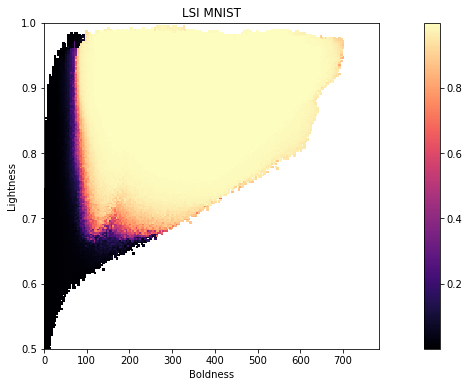

In [11]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(archive)
plt.title("LSI MNIST")
plt.xlabel("Boldness")
plt.ylabel("Lightness")
plt.show()

Here we display a grid of digits generated from a selected set of latent vectors in the archive with increasing boldness on the x axis and increasing lightness on the y axis.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


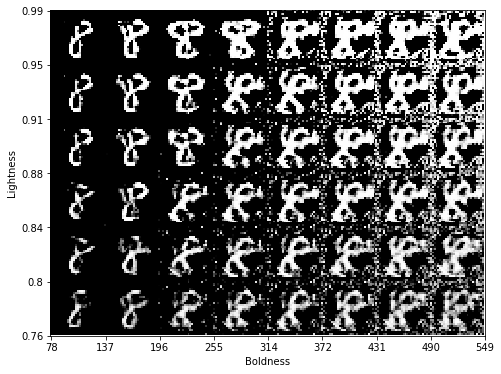

In [12]:
from torchvision.utils import make_grid

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest', cmap='gray')


def show_grid_img(x_start, x_num, y_start, y_num, step_size, elites):
    x_range = np.arange(x_start, x_start+step_size*x_num, step_size)
    y_range = np.arange(y_start, y_start+step_size*y_num, step_size)
    grid_indexes = [(x, y) for y in np.flip(y_range) for x in x_range]
    
    imgs = []
    for index in grid_indexes:
        x, y = index
        sol_row = elites[(elites["index_0"] == x) & (elites["index_1"] == y)]
        if sol_row.empty:
            print(f"Index ({x}, {y}) solution does not exist at the specified indexes.")
            return
        latent_vec = sol_row.iloc[0]["solution_0":].to_numpy()
        with torch.no_grad():
            img = generator(torch.tensor(latent_vec.reshape(1, nz), dtype=torch.float32))
            imgs.append(img.reshape(1, *img_size))

    fig = plt.figure(figsize=(8, 6))
    img_grid = make_grid(imgs, nrow=8, padding=0)
    show(img_grid)

    # change labels to be bc values
    plt.xlabel("Boldness")
    plt.ylabel("Lightness")
    x_ticklabels = [round(archive.boundaries[0][i]) 
                    for i in [x_start + step_size*k 
                    for k in range(x_num+1)]]
    y_ticklabels = [round(archive.boundaries[1][i], 2) 
                    for i in [y_start+step_size*y_num - step_size*k 
                    for k in range(y_num+1)]]
    plt.xticks([img_size[0]*x for x in range(x_num+1)], x_ticklabels)
    plt.yticks([img_size[0]*x for x in range(y_num+1)], y_ticklabels)
    
    plt.show()

elites = archive.as_pandas()
show_grid_img(20, 8, 105, 6, 15, elites)